In [1]:
# Install Kaggle library
!pip install -q kaggle

# Make a directory for Kaggle and move the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d mdkhurshidjahan01/figshare-brain-tumor-dataset

# Unzip the downloaded dataset
!unzip figshare-brain-tumor-dataset.zip -d brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/mdkhurshidjahan01/figshare-brain-tumor-dataset
License(s): Apache 2.0
100% 434M/436M [00:20<00:00, 21.5MB/s]
100% 436M/436M [00:20<00:00, 22.0MB/s]
Archive:  figshare-brain-tumor-dataset.zip
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_103192.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_104263.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_105758.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_106611.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_107584.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_111735.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_114652.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_115499.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_121515.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_135912.

Found 2449 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 batch_normalization_10 (Ba  (None, 150, 150, 16)      64        
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 150, 150, 16)      2320      
                                                                 
 batch_normalization_11 (Ba  (None, 150, 150, 16)      64        
 tchNormalization)                                               
                                                                 
 max_

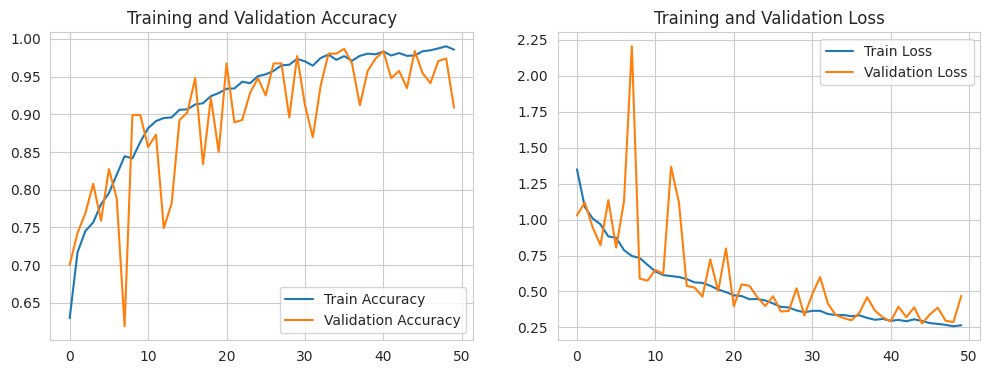

10/10 [==============================] - 3s 259ms/step


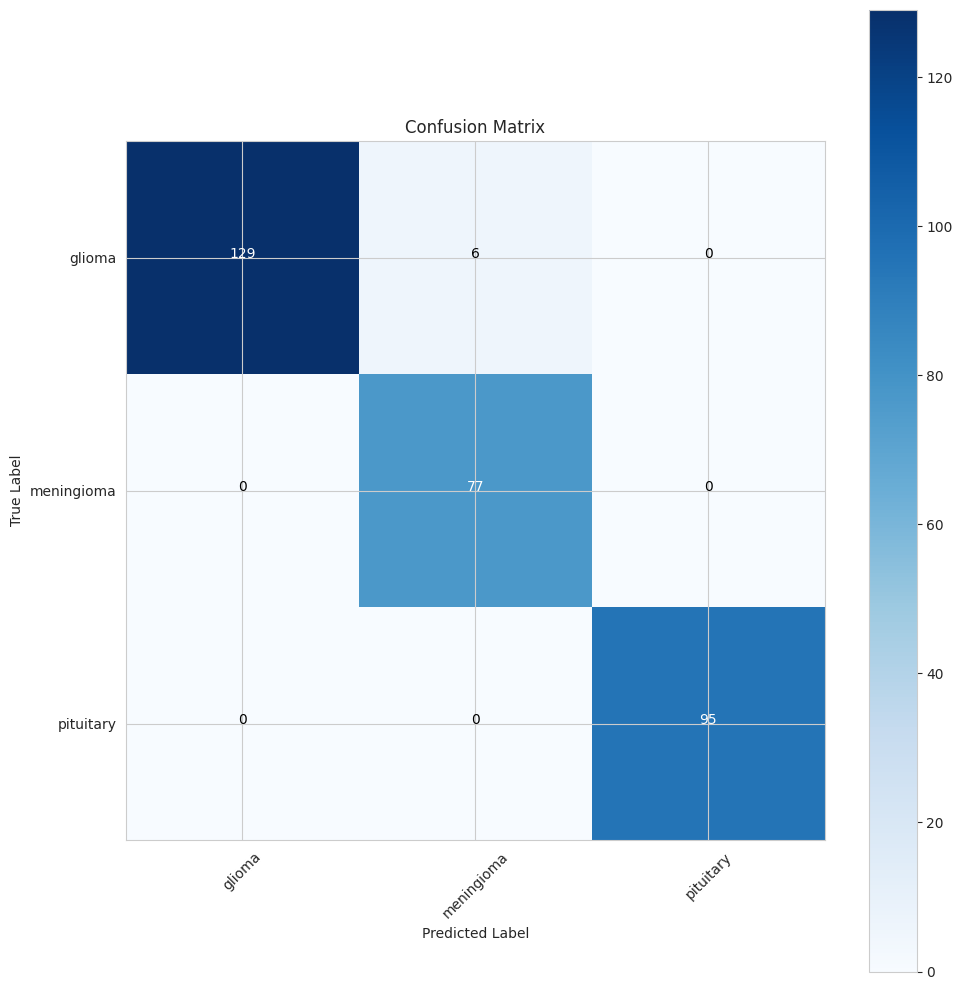

              precision    recall  f1-score   support

      glioma       1.00      0.96      0.98       135
  meningioma       0.93      1.00      0.96        77
   pituitary       1.00      1.00      1.00        95

    accuracy                           0.98       307
   macro avg       0.98      0.99      0.98       307
weighted avg       0.98      0.98      0.98       307



In [4]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

# Paths to your training and testing data
train_data_path = '/content/brain_tumor_dataset/Fig Share/Training'
test_data_path = '/content/brain_tumor_dataset/Fig Share/Testing'

# Create dataframes for training and testing data
def create_dataframe(data_path):
    filepaths = []
    labels = []
    folds = os.listdir(data_path)
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        filelists = os.listdir(f_path)
        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='label')
    return pd.concat([Fseries, Lseries], axis=1)

train_df = create_dataframe(train_data_path)
test_df = create_dataframe(test_data_path)

# Split test data into validation and test sets
valid, test = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)

img_size = (150, 150)
batch_size = 32

# ImageDataGenerators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

img_shape = (img_size[0], img_size[1], 3)
classes = train_gen.class_indices
num_class = len(classes)

model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1), input_shape=img_shape),
    BatchNormalization(),
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(128, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f'\nTesting loss: {test_loss}, Testing accuracy: {test_acc}\n')

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

Epochs = 50
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=[TestAccuracyCallback(), checkpoint, lr_scheduler])

# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate on training, validation, and test sets
train_score = best_model.evaluate(train_gen, steps=len(train_gen), verbose=1)
valid_score = best_model.evaluate(valid_gen, steps=len(valid_gen), verbose=1)
test_score = best_model.evaluate(test_gen, steps=len(test_gen), verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Plot training & validation accuracy and loss values
epochs_range = range(Epochs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.show()

# Generate predictions
preds = best_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Generate confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

# Define the model
img_shape = (128, 128, 3)  # Example input shape, adjust as needed
num_class = 8  # Number of classes, adjust as needed

model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1), input_shape=img_shape),
    BatchNormalization(),
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(128, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_class, activation='softmax')
])

# Generate the plot
plot_model(model, to_file='/mnt/data/model_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
